In [1]:
import pandas as pd
import os
from glob import glob

# Directory containing the CSV files
folder_path = '/content/drive/MyDrive/cluster 1'  # Replace with your Google Drive local path or mount path

# List of all CSV files in the directory
csv_files = glob(os.path.join(folder_path, "*.csv"))

# List to store individual DataFrames
dataframes = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        df['Phytochemical Name'] = os.path.basename(file).replace(".csv", "")
        dataframes.append(df[['Phytochemical Name', 'Common name']])
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Concatenate all DataFrames
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged file
merged_df.to_csv("merged_phytochemicals.csv", index=False)


In [3]:
import pandas as pd
import os
from glob import glob

# Set your folder path here
folder_path = '/content/drive/MyDrive/cluster 1'  # Replace with your actual path

# Collect all CSV files
csv_files = glob(os.path.join(folder_path, "*.csv"))

merged_rows = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        phytochemical_name = os.path.basename(file).replace(".csv", "")
        for _, row in df.iterrows():
            common_names = str(row['Common name']).split()
            for name in common_names:
                merged_rows.append({
                    "Phytochemical Name": phytochemical_name,
                    "Common name": name
                })
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Create the final DataFrame
merged_df = pd.DataFrame(merged_rows)

# Save to a new CSV file
merged_df.to_csv("cleaned_merged_phytochemicals.csv", index=False)

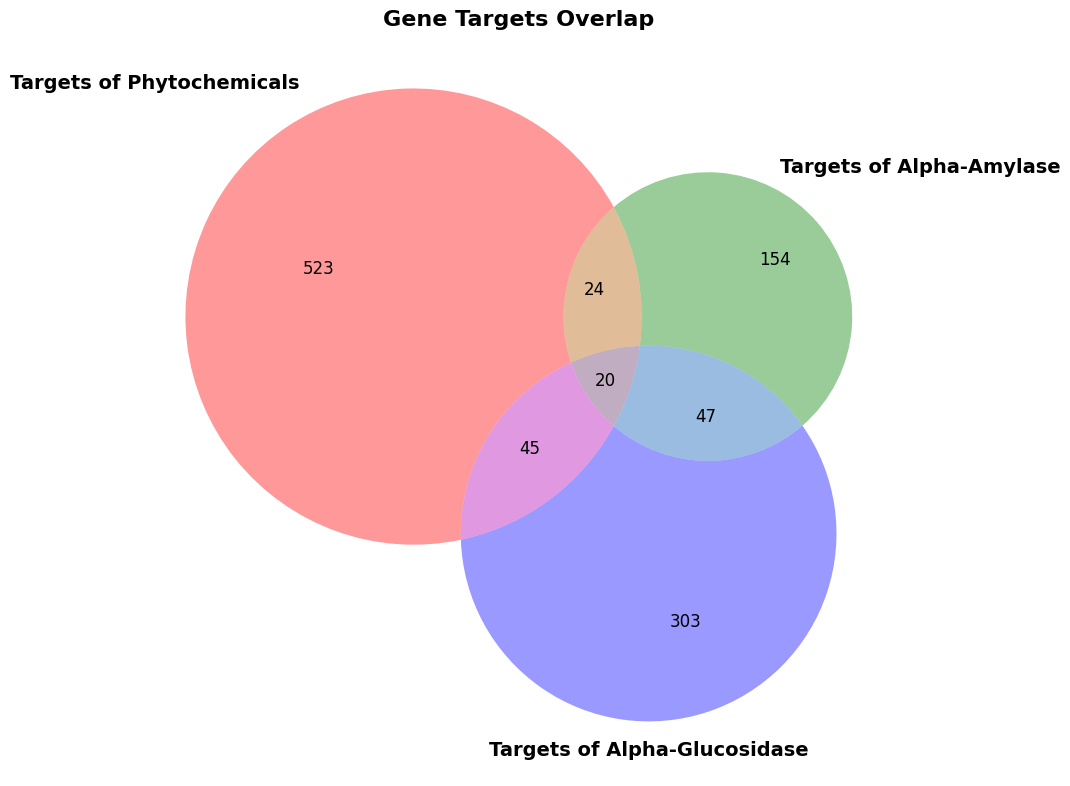

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Load the data
phytochem_df = pd.read_csv('cleaned_merged_phytochemicals.csv')
amylase_df = pd.read_csv('targets of alpha-amylase.csv')  # Replace with actual filename
glucosidase_df = pd.read_csv('targets of alpha-glucosidase.csv')  # Replace with actual filename

# Extract gene sets
genes_phytochem = set(phytochem_df['Common name'].dropna().astype(str).str.upper())
genes_amylase = set(amylase_df['Gene Symbol'].dropna().astype(str).str.upper())
genes_glucosidase = set(glucosidase_df['Gene Symbol'].dropna().astype(str).str.upper())

# Find common genes
common_genes = genes_phytochem & genes_amylase & genes_glucosidase

# Save common genes
common_genes_df = pd.DataFrame(sorted(common_genes), columns=["Common Genes"])
common_genes_df.to_csv("common_genes.csv", index=False)

# Create Venn diagram
plt.figure(figsize=(10, 8))
venn = venn3(
    [genes_phytochem, genes_amylase, genes_glucosidase],
    set_labels=('Targets of Phytochemicals', 'Targets of Alpha-Amylase', 'Targets of Alpha-Glucosidase')
)

# Style improvements
for text in venn.set_labels:
    text.set_fontsize(14)
    text.set_fontweight('bold')

for text in venn.subset_labels:
    if text:
        text.set_fontsize(12)

plt.title('Gene Targets Overlap', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save figure
plt.savefig("venn_diagram.png", dpi=600)
plt.show()

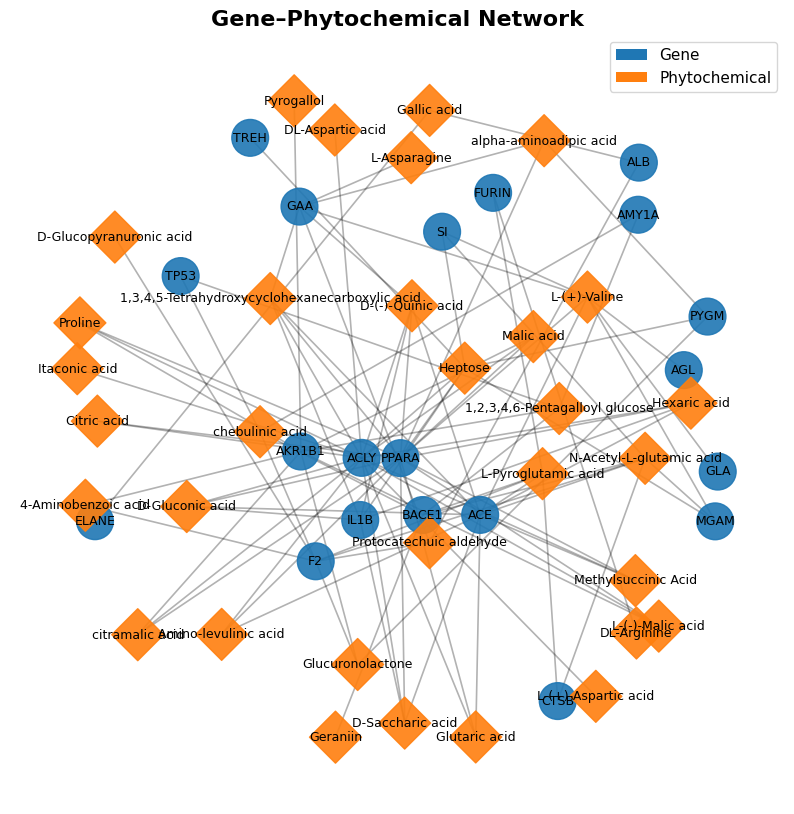

In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# -------- Gene list --------
genes_of_interest = [
    "ACE", "ACLY", "AGL", "AKR1B1", "ALB", "AMY1A", "BACE1", "CTSB", "ELANE",
    "F2", "FURIN", "GAA", "GLA", "IL1B", "MGAM", "PPARA", "PYGM", "SI", "TP53", "TREH"
]

# -------- Load and filter phytochemical associations --------
phytochem_df = pd.read_csv("cleaned_merged_phytochemicals.csv")
phytochem_df['Common name'] = phytochem_df['Common name'].str.upper()
filtered_df = phytochem_df[phytochem_df['Common name'].isin(genes_of_interest)]

# -------- Build Graph --------
G = nx.Graph()

# Add nodes and edges
edges = []
for _, row in filtered_df.iterrows():
    gene = row['Common name']
    phytochemical = row['Phytochemical Name']
    G.add_node(gene, type='gene')
    G.add_node(phytochemical, type='phytochemical')
    G.add_edge(gene, phytochemical)
    edges.append({'Gene': gene, 'Phytochemical': phytochemical})

# Save edge list to CSV
edges_df = pd.DataFrame(edges)
edges_df.to_csv("gene_phytochemical_interactions.csv", index=False)

# -------- Visualization --------
pos = nx.spring_layout(G, k=1.2, seed=42)  # more spread

# Color and shape
color_map = {'gene': '#1f77b4', 'phytochemical': '#ff7f0e'}
node_shapes = {'gene': 'o', 'phytochemical': 'D'}
labels = {n: n for n in G.nodes()}

# Large figure size for space
plt.figure(figsize=(10, 10))

# Draw nodes by type
for ntype in node_shapes:
    nodelist = [n for n in G.nodes() if G.nodes[n]['type'] == ntype]
    nx.draw_networkx_nodes(
        G, pos, nodelist=nodelist,
        node_color=[color_map[ntype]] * len(nodelist),
        node_shape=node_shapes[ntype],
        node_size=700, alpha=0.9, label=ntype.capitalize()
    )

# Edges and labels
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.2)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

# Legend
legend_elements = [
    Patch(facecolor=color_map['gene'], label='Gene'),
    Patch(facecolor=color_map['phytochemical'], label='Phytochemical')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=11)

plt.title("Gene–Phytochemical Network", fontsize=16, fontweight='bold')
plt.axis('off')

# Save image
plt.savefig("gene_phytochemical_network_spacious.png", dpi=600)
plt.show()

In [14]:
!pip install gprofiler-official

In [15]:
from gprofiler import GProfiler
import pandas as pd

# List of genes
genes = [
    "ACE", "ACLY", "AGL", "AKR1B1", "ALB", "AMY1A", "BACE1", "CTSB", "ELANE",
    "F2", "FURIN", "GAA", "GLA", "IL1B", "MGAM", "PPARA", "PYGM", "SI", "TP53", "TREH"
]

# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

# Run enrichment
results = gp.profile(
    organism='hsapiens',  # human
    query=genes,
    sources=["GO:BP", "KEGG", "REAC"]  # Biological process, KEGG, Reactome
)

# Filter for significant terms
significant_results = results[results['p_value'] < 0.05]

# Save results
significant_results.to_csv("gprofiler_significant_pathways.csv", index=False)

# Show top 5 results
print(significant_results[['source', 'name', 'p_value']].head())

  source                               name       p_value
0   KEGG      Starch and sucrose metabolism  6.282651e-11
1  GO:BP     carbohydrate metabolic process  9.649560e-10
2  GO:BP     carbohydrate catabolic process  3.333923e-09
3  GO:BP  oligosaccharide metabolic process  4.576865e-08
4  GO:BP     disaccharide metabolic process  3.154081e-07


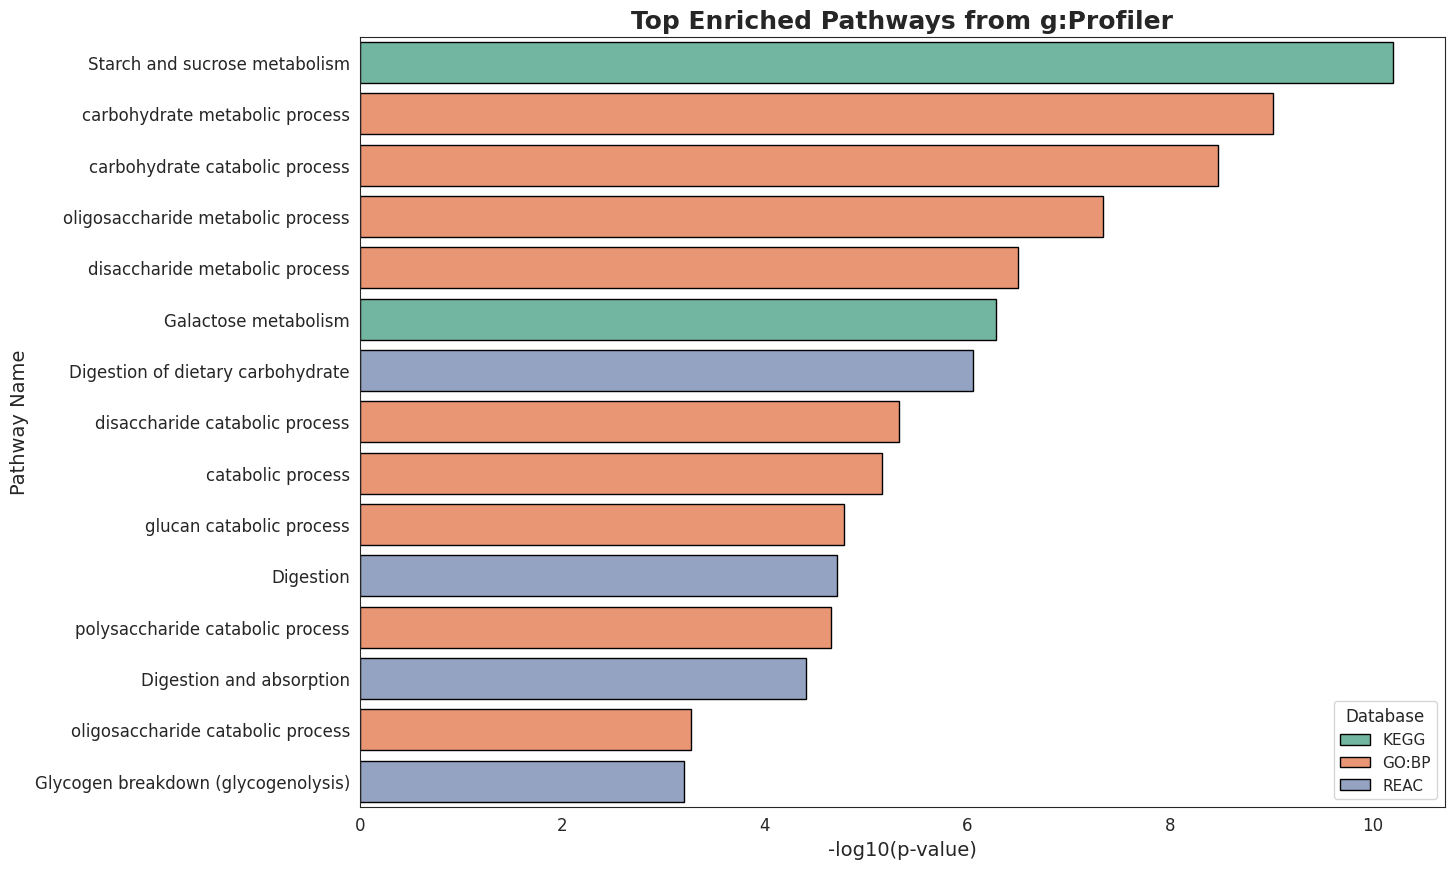

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("gprofiler_significant_pathways.csv")
df["log_pval"] = -np.log10(df["p_value"])

# Take top 15 pathways
top_df = df.sort_values("p_value").head(15)

# Set visual style: Keep axes, remove grid
sns.set_style("white")  # white background, no grid
plt.figure(figsize=(14, 10))

# Barplot
barplot = sns.barplot(
    data=top_df,
    x="log_pval",
    y="name",
    hue="source",
    palette="Set2",
    dodge=False,
    edgecolor='black'
)

# Enhancements
plt.title("Top Enriched Pathways from g:Profiler", fontsize=18, fontweight='bold')
plt.xlabel("-log10(p-value)", fontsize=14)
plt.ylabel("Pathway Name", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Database", fontsize=11, title_fontsize=12, loc='lower right')

# Keep axes, remove only background grid
barplot.set_facecolor("white")
plt.gca().set_axisbelow(True)
plt.grid(False)  # disables both major/minor grid lines

# Save final clean figure
plt.savefig("gprofiler_pathway_barplot_cleaned.png", dpi=600, bbox_inches='tight')
plt.show()